Authors: *Alessia Cotroneo - Alessandro Del Vitto - Michele Di Sabato* 

In this Notebook we implement Fine Tuning on the VGG16 architecture. We have decided to include after the VGG16 layers two additional ones constructed as follows:

---

```

conv1 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(x)
pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

```
---
We added the two pairs of Conv2D + MaxPooling2D since we noticed that the switch from the feature extraction layers and the fully connected ones was very quick. Moreover, according to the universal approximation theorem we used two dense layers after the feature extraction part.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd /gdrive/MyDrive/Colab Notebooks/ANN&DL First Challenge
# %cd /gdrive/MyDrive/path/to/your/folder

/gdrive/MyDrive/Colab Notebooks/ANN&DL First Challenge


In [3]:
!unzip dataset.zip

In [3]:
dataset_dir = 'training'

## Import libraries, mount the Drive and set seeds

In [4]:
# We import the packages provo a modificare
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

!pip install visualkeras
import visualkeras

# Random seed for reproducibility
seed = 123

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.7.0


## Definition of useful functions

### get_next_batch

In [5]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  # plot the "central" point to see the effect of the preprocessing
  print("Middle Pixel Value R: ", image[125][125][0])
  print("Middle Pixel Value G: ", image[125][125][1])
  print("Middle Pixel Value B: ", image[125][125][2])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

### create_folders_and_callbacks

In [6]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name,transfer_learning=False):
  
  # creates folders and callbacks, collected into a list, since the argument "callbacks" in the function .fit() requires a list

  if transfer_learning:
    exps_dir = os.path.join('CNN_TL')
  else:
    exps_dir = os.path.join('CNN')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir) # creates and SETS the directory if not found

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
                                                                  # histogram_freq = 5 means that i want to save 1 in 5 epochs (e.g. 1, 6, 6+5, ...)
                                                                  # histogram_freq = 1 means that i want to save 1 in 5 epochs (e.g. 1, 2, 3, ...)
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = "max", patience=20, restore_best_weights=True)
  #es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = "min", patience=30, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

## Model's parameters

In [7]:
input_size = 256
input_shape = (input_size, input_size, 3)
epochs = 50
batch_size = 16

## Split the data into training and validation sets

In [8]:
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

# parameters for the ImageDataGenerator function (preprocessing)
reshape_mean = False
reshape_sd   = False
use_data_augmentation = True

from tensorflow.keras.applications.vgg16 import preprocess_input

if use_data_augmentation:
  train_data_gen = ImageDataGenerator(validation_split=0.2, samplewise_center = reshape_mean, samplewise_std_normalization = reshape_sd,
                                      rotation_range = 30,
                                      height_shift_range = 50,
                                      width_shift_range = 50,
                                      zoom_range = 0.3,
                                      horizontal_flip = True,
                                      vertical_flip = True,
                                      fill_mode = "constant",
                                      rescale = 1/255.,
                                      preprocessing_function = preprocess_input)
else:
  train_data_gen = ImageDataGenerator(validation_split=0.2,
                                      rescale = 1/255.,
                                      preprocessing_function = preprocess_input)  
target_size = 256
train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(target_size,target_size),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed,
                                               subset="training")
val_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(target_size,target_size),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed,
                                               subset="validation")

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


## Load vgg16

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

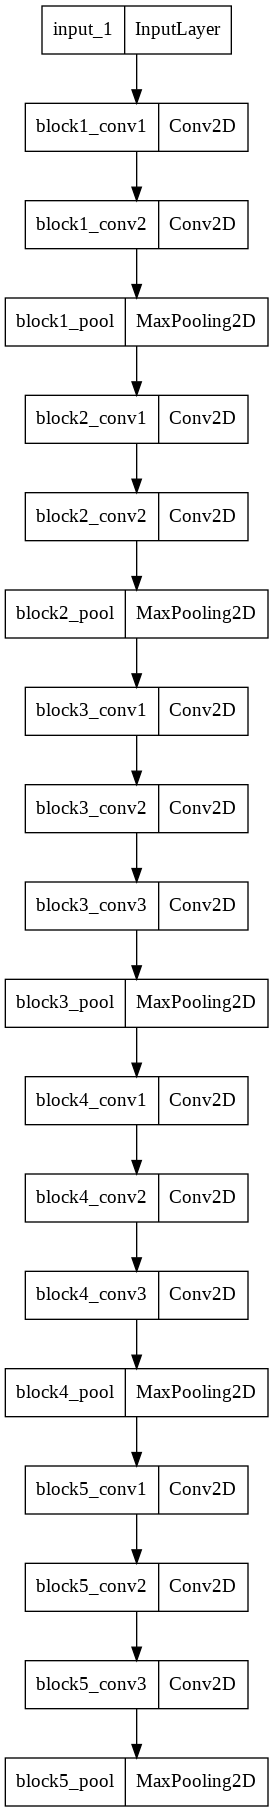

In [11]:
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3) # vgg16 has images of size 224x244 as input
)
supernet.summary()
tfk.utils.plot_model(supernet)

## Design the architecture

In [12]:
supernet.trainable = False
input_shape = 256
new_size = 224
inputs = tfk.Input(shape=(input_shape,input_shape,3))
x = tfkl.Resizing(new_size, new_size, interpolation="bicubic")(inputs)
x = supernet(x)

conv1 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(x)
pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

x = tfkl.Flatten(name='Flattening')(pool2)
x = tfkl.Dense(
        128, 
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
x = tfkl.Dropout(0.2, seed=seed)(x)
x = tfkl.Dense(
        128, 
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
x = tfkl.Dropout(0.2, seed=seed)(x)
outputs = tfkl.Dense(
        14, 
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)


    # Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy') #if tf basso

## Visualise the architecture

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 128)         589952    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 128)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          73792     
                                                             

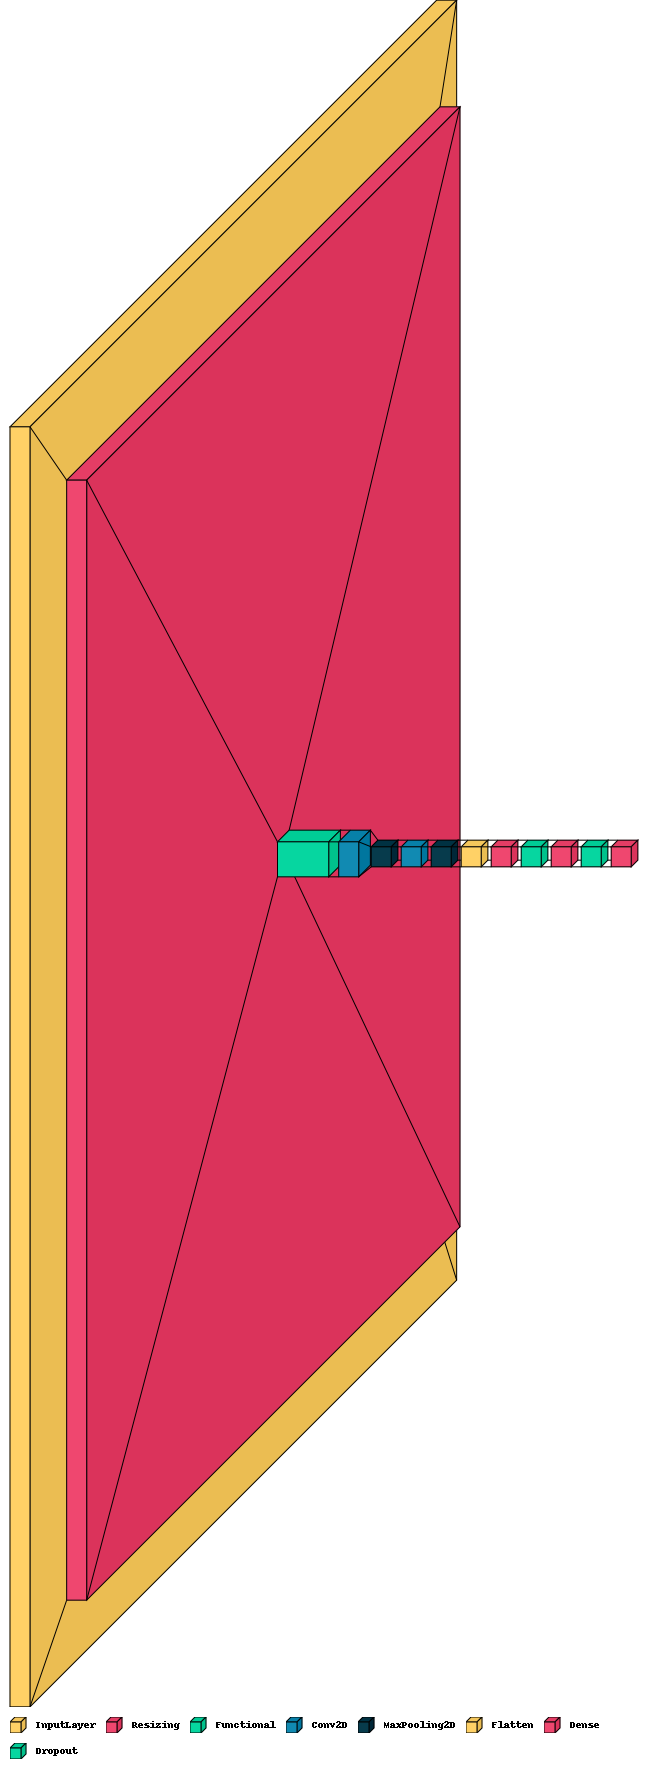

In [13]:
tl_model.summary()
visualkeras.layered_view(tl_model, legend=True, spacing=10, scale_xy=5)

## Fine tuning

In [14]:
ft_model = tl_model
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 128)         589952    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 128)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          73792     
                                                             

In [15]:
ft_model.get_layer('vgg16').trainable = True
#for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
#   print(i, layer.name, layer.trainable)

In [16]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 128)         589952   

## Compile the model

In [17]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

## Fit the model

In [1]:
epochs = 50
batch_size = 16
FT_vgg16_callbacks = create_folders_and_callbacks(model_name='model_FT', transfer_learning = True)
ft_history = ft_model.fit(
    x = train_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = FT_vgg16_callbacks
).history